In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from fomo.preprocess import read_benchmark_data, create_tfds

# Download data

- Download the data from [Zenodo](https://zenodo.org/record/7708544)
- Make sure you have train, validation and test files for the pft of your choice
- Keep all the files in the same folder (e.g. `model_input`)

# Load the data

In [4]:
pft = "beech"
train, val, test, bins = read_benchmark_data("model_input/", pft = pft)

test_ds, test_scale = create_tfds(test, normalize = True)  # Normalize and create tensorflow dataset
train_ds, train_scale = create_tfds(train, normalize = True)
train_ds = train_ds.batch(1024, drop_remainder=True)

2023-09-28 11:59:53.029046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-28 11:59:53.029095: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-28 11:59:53.029122: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (frontend1): /proc/driver/nvidia/version does not exist
2023-09-28 11:59:53.029752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Run the Model

In [5]:
model_path = "saved_model/SharedDecoderConvVAE_beta_1.5_lr_0.1_e-3_latent_dim_32_epoch_150.tf"
model = tf.keras.models.load_model(model_path)

In [6]:
latent_list = []
recons_list = []
x_list = []        
y_list = []
mu_list = []
log_var_list = []

for i, (x, _, y)  in enumerate(train_ds):

    latent, recons, mu, log_var = model(x)
    recons_list.append(recons)
    x_list.append(x)
    latent_list.append(latent)
    y_list.append(y)
    mu_list.append(mu)
    log_var_list.append(log_var)

x = np.vstack(x_list)
r = np.vstack(recons_list)
z = np.vstack(latent_list)
y = np.hstack(y_list)
mu = np.vstack(mu_list)
log_var = np.vstack(log_var_list)

# Figure 5 Anomaly

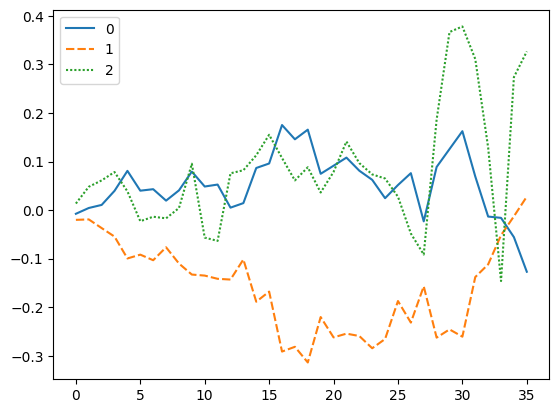

In [7]:
weather_anomaly = x[y>=np.percentile(y, 90)]
sns.lineplot(np.squeeze(weather_anomaly.mean(axis=0)))
plt.show()

# Figure 6 Latent Boxplot

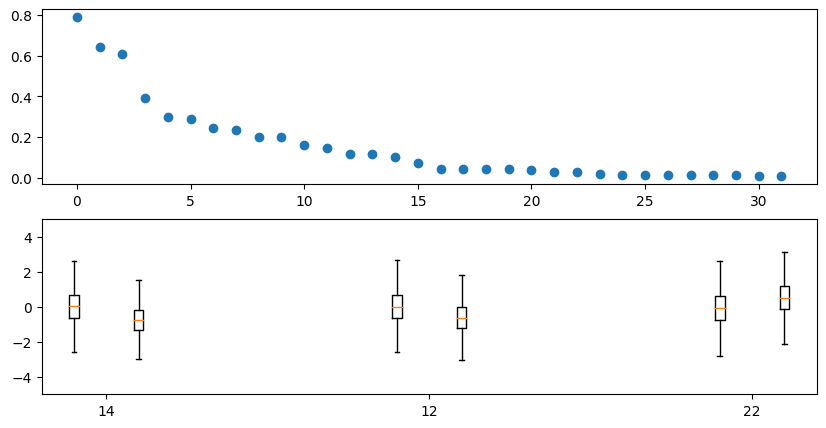

In [8]:

z_xtreme = z[y<np.percentile(y, 90)]
z_non_xtreme = z[y>=np.percentile(y, 90)]
y_xtreme = y[y>=np.percentile(y, 90)]

z_diff = (z_non_xtreme.mean(axis = 0)- z_xtreme.mean(axis = 0))
index_list = np.argsort(np.abs(z_diff))[::-1]

fig, axes = plt.subplots(2,1, figsize = (10,5))
axes[0].scatter(np.arange(32),np.sort(np.abs(z_diff))[::-1])

for i, index in enumerate(index_list[:3]):
    axes[1].boxplot(z_xtreme[:,index], positions=[5*i],  showfliers=False)
    axes[1].boxplot(z_non_xtreme[:,index], positions=[5*i+1], showfliers= False)

axes[1].set_xticks([0.5,5.5,10.5])
axes[1].set_xticklabels(index_list[:3]+1)
axes[1].set_ylim((-5,5))
plt.show()

# Figure 7 Prototype

In [9]:
for layer in model.layers:
    decoder = layer

(mu_d, mu_s, _), (sigma_d, sigma_s, _) = train_scale
    

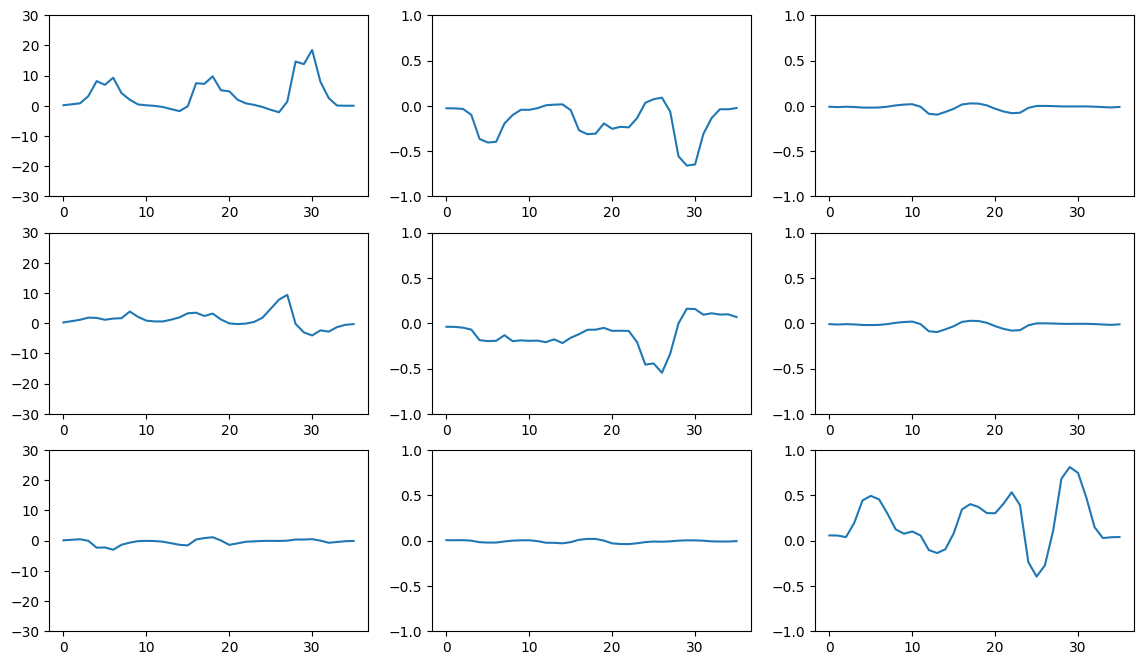

In [10]:
fig, axes = plt.subplots(3,3, figsize = (14,8))

top_k = 3
out = np.zeros((top_k, 36, 3, 3))
for i, index in enumerate(index_list[:top_k]):
    for val in range(2,3):
        custom_z = z.mean(axis=0).reshape(1, -1)
        custom_z[0, index] += np.sign(z_diff[index])*(val)
        if index < 8:
            custom_z[0, index+8] += np.corrcoef(z[:,index], z[:,index+8])[0,1] * np.sign(z_diff[index])*(val)
        elif index < 16:
            custom_z[0, index-8] += np.corrcoef(z[:,index], z[:,index-8])[0,1] * np.sign(z_diff[index])*(val)

        z_rad = custom_z[:, 0:8]
        z_precip = custom_z[:, 8:16]
        z_temp = custom_z[:, 16:24]
        z_shared = custom_z[:, 24:32]
        
        n_sample = 10
        sample_index = np.argsort(np.square(z[:,index]-custom_z[:,index]))[:n_sample]
            
        out[i, :, 0, val] = decoder(np.concatenate([z_rad, z_shared], axis = 1))[0,:,0,0]*sigma_d[:,0,0]
        out[i, :, 1, val] = decoder(np.concatenate([z_precip, z_shared], axis = 1))[0,:,0,0]*sigma_d[:,1,0]
        out[i, :, 2, val] = decoder(np.concatenate([z_temp, z_shared], axis = 1))[0,:,0,0]*sigma_d[:,2,0]

        axes[i, 0].plot(out[i, :, 0, val])
        axes[i, 0].set_ylim(-30,30)
        

        axes[i, 1].plot(out[i, :, 1, val])
        axes[i, 1].set_ylim(-1,1)
    
        axes[i, 2].plot(out[i, :, 2, val])
        axes[i, 2].set_ylim(-1,1)


# Figure 9 Correlation Plot

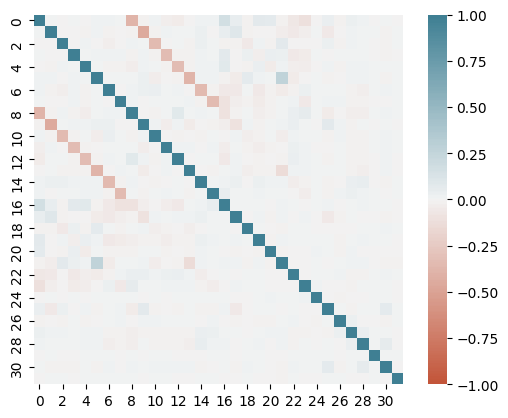

In [11]:
corr_mat = np.corrcoef(z.T)
sns.heatmap(corr_mat, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
plt.show()